In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d quora/question-pairs-dataset

Dataset URL: https://www.kaggle.com/datasets/quora/question-pairs-dataset
License(s): other
question-pairs-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('question-pairs-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('questions.csv')

In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
!pip install contractions
!pip install nltk

In [ ]:
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = stopwords.words('english')
ps = PorterStemmer()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess_text(text):
    text = text.lower().strip()
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = contractions.fix(text)
    text = word_tokenize(text)
    text = [word for word in text if word.isalnum()]
    text = [word for word in text if word not in stop_words]
    text = [ps.stem(word) for word in text]
    text = ' '.join(text)
    return text

In [ ]:
df['question1'] = df['question1'].apply(preprocess_text)
df['question2'] = df['question2'].apply(preprocess_text)

In [ ]:
!pip install numpy==1.24.3
!pip install gensim

In [ ]:
import gensim
from nltk import sent_tokenize
from gensim.utils import simple_preprocess
from tqdm import tqdm

In [ ]:
df_stacked = pd.DataFrame({
    'questions': pd.concat([df['question1'], df['question2']])
})

In [ ]:
questions = []
for doc in df_stacked['questions']:
    for sentence in sent_tokenize(doc):
        questions.append(simple_preprocess(sentence))

In [ ]:
model = gensim.models.Word2Vec(
    window = 10,
    min_count = 2,
    vector_size=300
)

In [ ]:
model.build_vocab(questions)
model.train(questions, total_examples=model.corpus_count, epochs=model.epochs)

(20017518, 21240930)

In [ ]:
len(model.wv.index_to_key)

33817

In [ ]:
model.wv.save("Questions300_vectors.kv")
model.save("Questions300_w2v.model")

In [ ]:
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    # Check if doc is empty after removing OOV words
    if not doc:
        # Return a zero vector of the appropriate size if doc is empty
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

In [ ]:
df['text'] = df['question1'] + ' ' + df['question2']
df = df.sample(30000, random_state = 42)

In [ ]:
X = []
for doc in tqdm(df['text'].values):
    X.append(document_vector(doc))

100%|██████████| 30000/30000 [00:53<00:00, 556.92it/s]


In [ ]:
X = np.array(X)

In [ ]:
df = np.column_stack((X, np.array(df['is_duplicate'])))

In [ ]:
df = pd.DataFrame(df)

In [ ]:
X = df.drop(300, axis = 1)
y = df[300]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
print("Training Random Forest Model")
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test,rf_pred)
print(f"Trained Random Forest Model ACCURACY = {accuracy}")
print('-'*10 + '\n')
print("Training XGB Model")
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
xgb_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test,xgb_pred)
print(f"Trained XGB Model ACCURACY = {accuracy}")
print('-'*10+ '\n')

Training Random Forest Model
Trained Random Forest Model ACCURACY = 0.7486666666666667
----------

Training XGB Model
Trained XGB Model ACCURACY = 0.7401666666666666
----------



# ***T1***

In [ ]:
!pip install numpy==1.24.3 # this ensures NumPy 1.24.3 which has dtypes attribute
!pip install --upgrade jax jaxlib # upgrade or reinstall jax and jaxlib to ensure compatibility
!pip install ot #installing ot again for compatibility
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install contractions
!pip install nltk
!pip install wordcloud
!pip install gensim

  Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.6.0 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.6.0 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow 2.18.0 requires

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
ERROR: Could not find a version that satisfies the requirement ot (from versions: none)
ERROR: No 

In [ ]:
import gensim
from nltk import sent_tokenize
from gensim.utils import simple_preprocess
from tqdm import tqdm

In [ ]:
df = pd.read_csv('questions.csv')

In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)

In [ ]:
df = df.sample(30000, random_state=2).reset_index()

In [ ]:
!pip install contractions
!pip install nltk

In [ ]:
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess_text(text):
    text = text.lower().strip()
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = contractions.fix(text)
    text = word_tokenize(text)
    text = [word for word in text if word.isalnum()]
    text = " ".join(text)
    return text

In [ ]:
df['question1'] = df['question1'].apply(preprocess_text)
df['question2'] = df['question2'].apply(preprocess_text)

In [ ]:
df['len_q1'] = df['question1'].apply(lambda x: len(x.split()))
df['len_q2'] = df['question2'].apply(lambda x: len(x.split()))

In [ ]:
def get_common_words(q1, q2):
    words1 = set(q1.split())
    words2 = set(q2.split())
    return len(words1 & words2)

In [ ]:
for i in range(len(df)):
    df.loc[i, 'common_words'] = get_common_words(df.loc[i, 'question1'], df.loc[i, 'question2'])

In [ ]:
def stopword_count(text):
    stp_text = [word for word in text.split() if word in stop_words]
    return len(stp_text)

In [ ]:
df['stop_words_q1'] = df['question1'].apply(stopword_count)
df['stop_words_q2'] = df['question2'].apply(stopword_count)

In [ ]:
def get_common_stpwords(q1, q2):
    stp_q1 = set([word for word in q1.split() if word in stop_words])
    stp_q2 = set([word for word in q2.split() if word in stop_words])
    return len(stp_q1 & stp_q2)

In [ ]:
for i in range(len(df)):
    df.loc[i, 'common_stpwords'] = get_common_stpwords(df.loc[i, 'question1'], df.loc[i, 'question2'])

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

In [ ]:
from fuzzywuzzy import fuzz
for i in range(len(df)):
    df.loc[i, 'fuzz_ratio'] = fuzz.ratio(df.loc[i, 'question1'], df.loc[i, 'question2'])
    df.loc[i, 'fuzz_partial_ratio'] = fuzz.partial_ratio(df.loc[i, 'question1'], df.loc[i, 'question2'])
    df.loc[i, 'token_sort_ratio'] = fuzz.token_sort_ratio(df.loc[i, 'question1'], df.loc[i, 'question2'])
    df.loc[i, 'token_set_ratio'] = fuzz.token_set_ratio(df.loc[i, 'question1'], df.loc[i, 'question2'])

In [ ]:
text_df = df[['question1', 'question2']]
df = df.drop(['question1', 'question2'], axis=1)

In [ ]:
def jaccard_similarity(q1, q2):
    s1 = set(word_tokenize(q1))
    s2 = set(word_tokenize(q2))
    if not s1 or not s2:
        return 0
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [ ]:
for i in range(len(df)):
    df.loc[i, 'j_sim'] = jaccard_similarity(text_df.loc[i, 'question1'], text_df.loc[i, 'question2'])

In [ ]:
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec
ps = PorterStemmer()

In [ ]:
model = Word2Vec.load("questions_w2v.model")

In [ ]:
sfty = 1e-04
df['cw_min'] = df['common_words'] / (df[['len_q1', 'len_q2']].min(axis=1) + sfty)
df['cw_max'] = df['common_words'] / (df[['len_q1', 'len_q2']].max(axis=1) + sfty)
df['cw_mean'] = df['common_words'] / (df[['len_q1', 'len_q2']].mean(axis=1) + sfty)

In [ ]:
df['cstp_min'] = df['common_stpwords'] / (df[['len_q1', 'len_q2']].min(axis=1) + sfty)
df['cstp_max'] = df['common_stpwords'] / (df[['len_q1', 'len_q2']].max(axis=1) + sfty)
df['cstp_mean'] = df['common_stpwords'] / (df[['len_q1', 'len_q2']].mean(axis=1) + sfty)

In [ ]:
df['cstp_stplen_min'] = df['common_stpwords'] / (df[['stop_words_q1', 'stop_words_q2']].min(axis=1) + sfty)
df['cstp_stplen_max'] = df['common_stpwords'] / (df[['stop_words_q1', 'stop_words_q2']].max(axis=1) + sfty)
df['cstp_stplen_mean'] = df['common_stpwords'] / (df[['stop_words_q1', 'stop_words_q2']].mean(axis=1) + sfty)

In [ ]:
df.columns

Index(['index', 'is_duplicate', 'len_q1', 'len_q2', 'common_words',
       'stop_words_q1', 'stop_words_q2', 'common_stpwords', 'fuzz_ratio',
       'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio', 'j_sim',
       'cw_min', 'cw_max', 'cw_mean', 'cstp_min', 'cstp_max', 'cstp_mean',
       'cstp_stplen_min', 'cstp_stplen_max', 'cstp_stplen_mean'],
      dtype='object')

<Axes: >

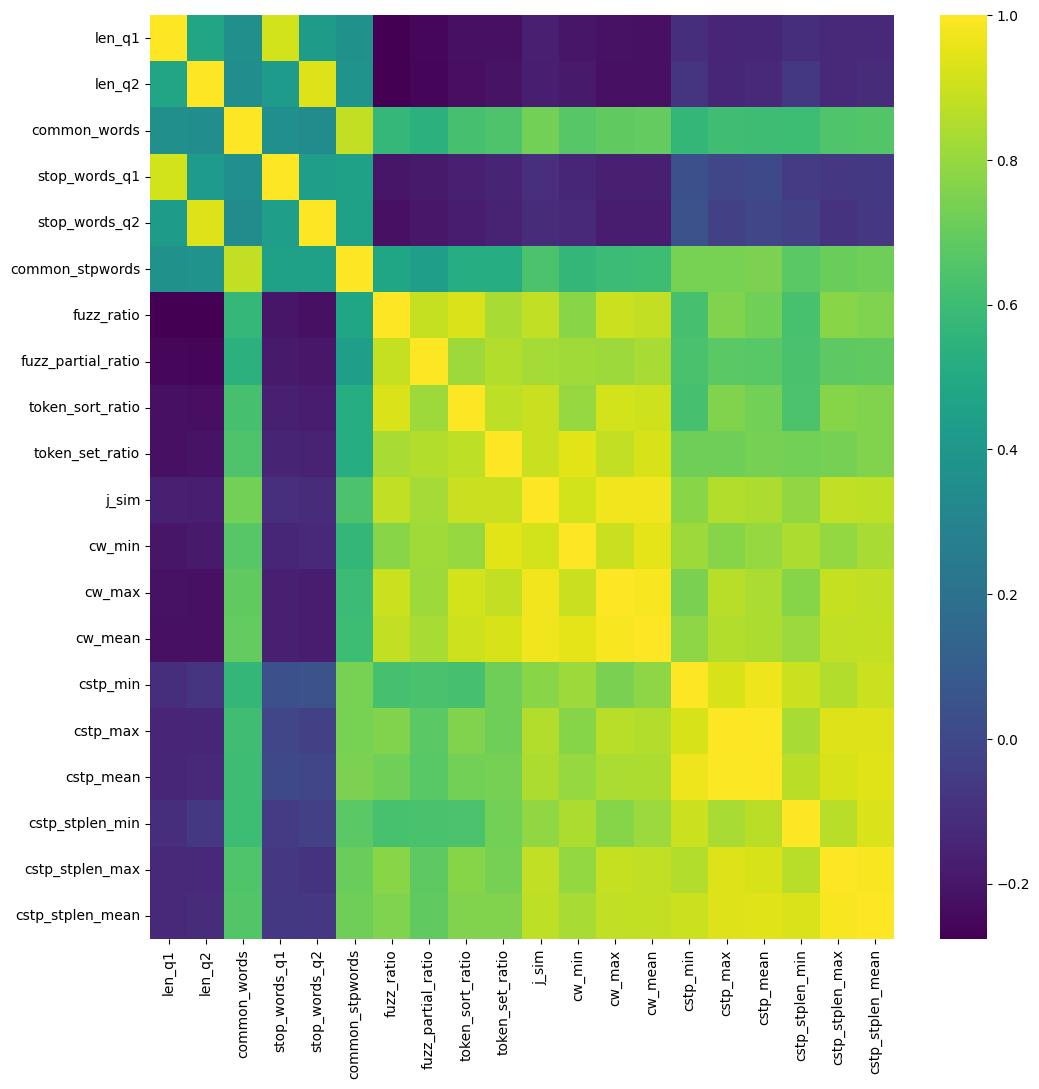

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), cmap='viridis')

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
y = df['is_duplicate']
df = df.drop(['index', 'is_duplicate'], axis = 1)
X = StandardScaler().fit_transform(df)

In [ ]:
from tqdm import tqdm

In [ ]:
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    # Check if doc is empty after removing OOV words
    if not doc:
        # Return a zero vector of the appropriate size if doc is empty
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

In [ ]:
text_df['text'] = text_df['question1'] + ' ' + text_df['question2']

In [ ]:
X_text = []
for doc in tqdm(text_df['text'].values):
    X_text.append(document_vector(doc))

100%|██████████| 30000/30000 [04:18<00:00, 115.99it/s]


In [ ]:
X = np.array(X)
X_text = np.array(X_text)
X = np.column_stack((X, X_text))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [ ]:
print("Training Random Forest Model")
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test,rf_pred)
print(f"Trained Random Forest Model ACCURACY = {accuracy}")
print('-'*10 + '\n')
print("Training XGB Model")
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
xgb_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test,xgb_pred)
print(f"Trained XGB Model ACCURACY = {accuracy}")
print('-'*10+ '\n')

Training Random Forest Model
Trained Random Forest Model ACCURACY = 0.7725
----------

Training XGB Model
Trained XGB Model ACCURACY = 0.7663333333333333
----------



In [ ]:
correlated_pairs = []
corr_mtrx = df.corr()
for i in range(len(df.columns)):
    for j in range(i+1):
        if i == j:
            continue
        if abs(corr_mtrx.iloc[i, j]) > 0.95:
            correlated_pairs.append((corr_mtrx.columns[i], corr_mtrx.columns[j]))

In [ ]:
correlated_pairs

[('cw_max', 'j_sim'),
 ('cw_mean', 'j_sim'),
 ('cw_mean', 'cw_min'),
 ('cw_mean', 'cw_max'),
 ('cstp_mean', 'cstp_min'),
 ('cstp_mean', 'cstp_max'),
 ('cstp_stplen_mean', 'cstp_stplen_max')]

dropping some features

In [ ]:
X = StandardScaler().fit_transform(df.drop(['cw_max', 'cw_min', 'cstp_min', 'cstp_max', 'cstp_stplen_mean'], axis=1))

In [ ]:
X = np.array(X)
X = np.column_stack((X, X_text))

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [ ]:
print("Training Random Forest Model")
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test,rf_pred)
print(f"Trained Random Forest Model ACCURACY = {accuracy}")
print('-'*10 + '\n')
print("Training XGB Model")
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
xgb_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test,xgb_pred)
print(f"Trained XGB Model ACCURACY = {accuracy}")
print('-'*10+ '\n')

Training Random Forest Model
Trained Random Forest Model ACCURACY = 0.7628333333333334
----------

Training XGB Model
Trained XGB Model ACCURACY = 0.7738333333333334
----------



In [ ]:
X = StandardScaler().fit_transform(df)

In [ ]:
X = np.array(X)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=16)
X = selector.fit_transform(X, y)

In [ ]:
X = np.column_stack((X, X_text))

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [ ]:
print("Training Random Forest Model")
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test,rf_pred)
print(f"Trained Random Forest Model ACCURACY = {accuracy}")
print('-'*10 + '\n')
print("Training XGB Model")
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
xgb_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test,xgb_pred)
print(f"Trained XGB Model ACCURACY = {accuracy}")
print('-'*10+ '\n')

Training Random Forest Model
Trained Random Forest Model ACCURACY = 0.761
----------

Training XGB Model
Trained XGB Model ACCURACY = 0.7733333333333333
----------



In [ ]:
X = StandardScaler().fit_transform(df)

In [ ]:
X = np.array(X)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.98)  # Retain 95% variance
X = pca.fit_transform(X)

In [ ]:
X = np.column_stack((X, X_text))

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [ ]:
print("Training Random Forest Model")
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test,rf_pred)
print(f"Trained Random Forest Model ACCURACY = {accuracy}")
print('-'*10 + '\n')
print("Training XGB Model")
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
xgb_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test,xgb_pred)
print(f"Trained XGB Model ACCURACY = {accuracy}")
print('-'*10+ '\n')

Training Random Forest Model
Trained Random Forest Model ACCURACY = 0.7501666666666666
----------

Training XGB Model
Trained XGB Model ACCURACY = 0.7603333333333333
----------



In [ ]:
X_q1 = []
for doc in tqdm(text_df['question1'].values):
    X_q1.append(document_vector(doc))
X_q2 = []
for doc in tqdm(text_df['question2'].values):
    X_q2.append(document_vector(doc))

100%|██████████| 30000/30000 [01:46<00:00, 282.89it/s]


In [ ]:
X = StandardScaler().fit_transform(df.drop(['cw_max', 'cw_min', 'cstp_min', 'cstp_max', 'cstp_stplen_mean'], axis=1))

In [ ]:
X = np.array(X)
X = np.column_stack((X, X_q1, X_q2))

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [ ]:
print("Training Random Forest Model")
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test,rf_pred)
print(f"Trained Random Forest Model ACCURACY = {accuracy}")
print('-'*10 + '\n')
print("Training XGB Model")
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
xgb_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test,xgb_pred)
print(f"Trained XGB Model ACCURACY = {accuracy}")
print('-'*10+ '\n')

Training Random Forest Model
Trained Random Forest Model ACCURACY = 0.7528333333333334
----------

Training XGB Model
Trained XGB Model ACCURACY = 0.764
----------



T2